# analysis of altimetric data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt

import gcsfs.mapping

#from h3 import h3
import pyinterp
from xhistogram.xarray import histogram

---

## not used for now

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46695 Dashboard: /user/apatlpo-itide_ops-9tzhb414/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [12]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=10)

In [ ]:
cluster

---

## load data

In [3]:
fs = gcsfs.GCSFileSystem(project='pangeo-cnes', token=None)
gcsmap = gcsfs.mapping.GCSMap('pangeo-cnes/alti/tp', gcs=fs)

In [4]:
ds = xr.open_zarr(gcsmap, consolidated=True)
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds0 = ds
ds

Dataset size = 8.8 GB


<xarray.Dataset>
Dimensions:         (time: 157384325)
Coordinates:
    latitude        (time) float64 dask.array<chunksize=(13107200,), meta=np.ndarray>
    longitude       (time) float64 dask.array<chunksize=(13107200,), meta=np.ndarray>
  * time            (time) datetime64[ns] 1992-12-31T23:20:35.775270144 ... 2002-04-24T07:56:09.359487744
Data variables:
    cycle           (time) int16 dask.array<chunksize=(13107200,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(13107200,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(13107200,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(13107200,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(13107200,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(13107200,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(13107200,), meta=np.ndarray>
    track           (time) int16 dask.

---

## xhistogram 

In [ ]:
#ds = ds0.chunk({'time':1e6}) #.isel(time=slice(0,int(1e7)))
ds = ds0.isel(time=slice(0,int(1e7)))
ds['longitude'] = (ds.longitude+180)%360 - 180
ds = ds.where((ds.longitude<10)&(ds.longitude>-70), drop=True)

distributed.scheduler - ERROR - Error in reevaluate occupancy
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/_common.py", line 340, in wrapper
    ret = self._cache[fun]
AttributeError: _cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/scheduler.py", line 4719, in reevaluate_occupancy
    if self.proc.cpu_percent() < 50:
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/__init__.py", line 1112, in cpu_percent
    pt2 = self._proc.cpu_times()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/_pslinux.py", line 1517, in wrapper
    return fun(self, *args, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/psutil/_pslinux.py", line 1704, in cpu_times
    values = self._parse_stat_file()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages

In [38]:
lon_bins = np.arange(-70, 10, 1)
lat_bins = np.arange(-90, 95, 1)
N = histogram(ds.longitude, ds.latitude, bins=[lon_bins, lat_bins])
sla_mean = (histogram(ds.longitude, ds.latitude, 
                      bins=[lon_bins, lat_bins], weights=ds.sla_filtered)/N) \
            .rename('sla_mean')
sla2_mean = (histogram(ds.longitude, ds.latitude, 
                       bins=[lon_bins, lat_bins], weights=ds.sla_filtered**2)/N)\
            .rename('sla2_mean')

In [39]:
sla_mean

<xarray.DataArray 'sla_mean' (longitude_bin: 79, latitude_bin: 184)>
dask.array<truediv, shape=(79, 184), dtype=float64, chunksize=(79, 184), chunktype=numpy.ndarray>
Coordinates:
  * longitude_bin  (longitude_bin) float64 -69.5 -68.5 -67.5 ... 6.5 7.5 8.5
  * latitude_bin   (latitude_bin) float64 -89.5 -88.5 -87.5 ... 91.5 92.5 93.5

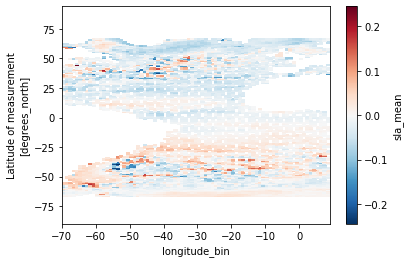

In [40]:
sla_mean.plot(x='longitude_bin', y='latitude_bin')

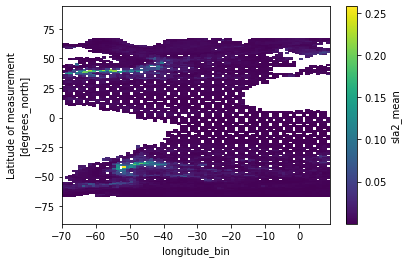

In [41]:
sla2_mean.plot(x='longitude_bin', y='latitude_bin')

---
## pyinterp approach

[pyinterp doc](https://pangeo-pyinterp.readthedocs.io/en/latest/examples.html)

In [9]:
ds = ds0.isel(time=slice(0,int(1e8))).chunk({'time':1e6})
#ds = ds0.where((ds.longitude<45)&(ds.longitude>-45), drop=True)
#ds = ds0 # crashes
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

Dataset size = 5.6 GB


In [10]:
ds = ds.persist()

In [15]:
binning = pyinterp.Binning2D(
    pyinterp.Axis(np.arange(-180, 180, 1), is_circle=True),
    pyinterp.Axis(np.arange(-90, 95, 1)))

In [ ]:
#mx, my = np.meshgrid(ds.longitude, ds.latitude)
binning.push(ds.longitude, ds.latitude, ds.mdt, simple=True)

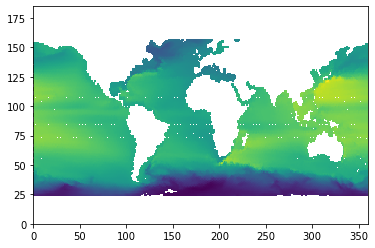

In [13]:
plt.pcolormesh(binning.variable('mean').T)

In [ ]:
binning.variable('mean')

In [8]:
np.asarray(ds.mdt).flatten().shape

(10000,)

---
## h3

In [ ]:
ds = ds.isel(time=slice(0,int(1e6)))
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

df = ds.to_dataframe()
df

In [ ]:
resolution = 7
%time df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], resolution), axis = 1)

In [ ]:
df

In [ ]:
df_stats = df.groupby('hex_id').mean()